In [3]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)
import zarr

scikit-allel 1.3.5


Load ZARR callset, extract GTs and associated annotations for scaffold_1 (makes things faster)

In [4]:
zarr_path = '/Users/dennistpw/Projects/microctonus/microctonus_genom/mh_scaf1.snp.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])

Read in metadata and check to see if is ordered the same as the callset. Add an index column specifying sample location in the callset and then sort accordingly

In [5]:
df_samples = pandas.read_csv('/Users/dennistpw/Projects/microctonus/microctonus_genom/mapping_QC_res_concerns.csv', delimiter=',')
samples = callset['samples']
samples_list = list(samples)
np.all(samples[:] == df_samples['sample_id'].values)

False

In [6]:
samples_callset_index = [samples_list.index(s) for s in df_samples['sample_id']]
df_samples['callset_index'] = samples_callset_index
#df_samples = df_samples.sort_values('callset_index')
df_samples = df_samples.sort_values('callset_index')
np.all(samples[:] == df_samples['sample_id'].values)

True

Function to plot a frequency distribution for any variant attribute:

In [7]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

Let's look at SNP depth:

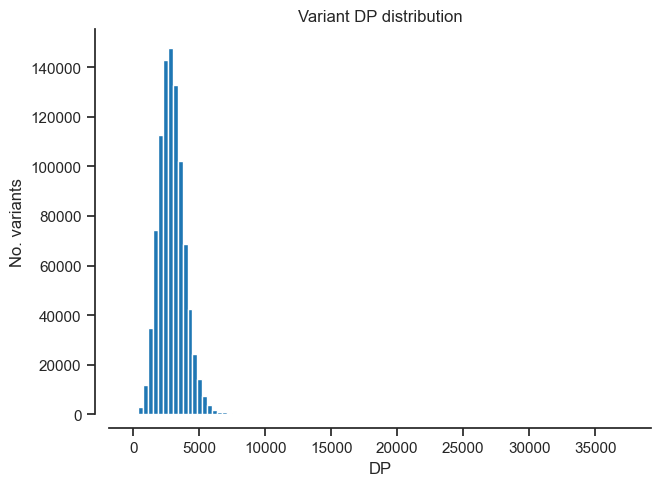

In [8]:
plot_variant_hist('DP', bins=100)

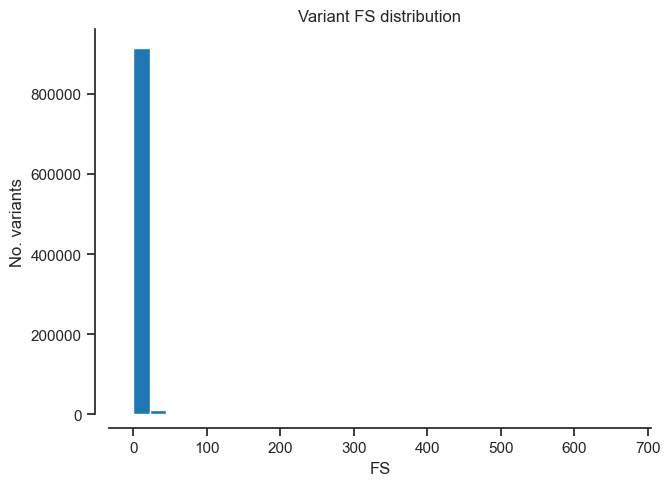

In [9]:
plot_variant_hist('FS')

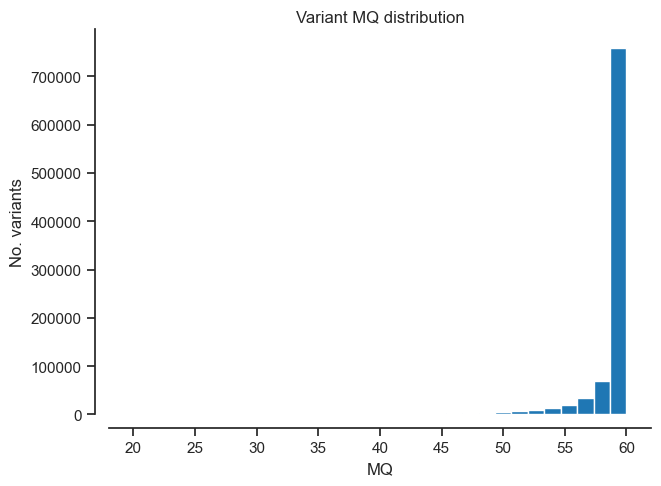

In [10]:
plot_variant_hist('MQ')

Plot QD. Roughly speaking, high numbers mean that evidence for variation is strong (concentrated), low numbers mean that evidence is weak (dilute).

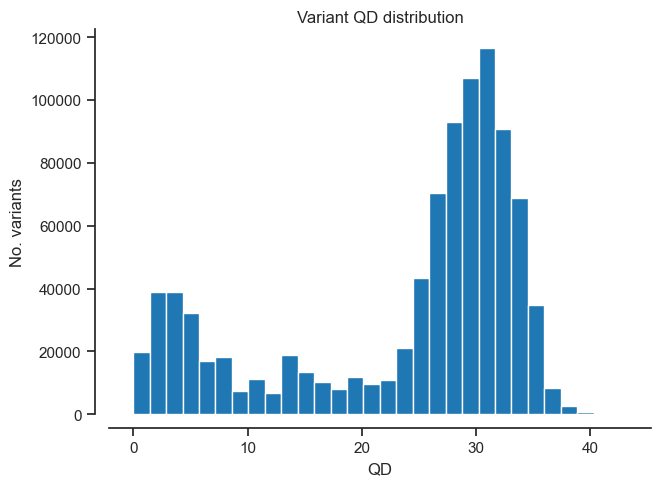

In [11]:
plot_variant_hist('QD')

Implement some filters (based on T and E):

In [12]:
filter_expression = '(QD > 10) & (MQ > 50) & (DP > 200) & (DP < 7000)'

In [13]:
variant_selection = variants.eval(filter_expression)[:]
np.count_nonzero(variant_selection)
np.count_nonzero(~variant_selection)
variants_pass = variants.compress(variant_selection)
variants_pass.shape

(739578,)

In [14]:
def plot_variantpass_hist(f, bins=30):
    x = variants_pass[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

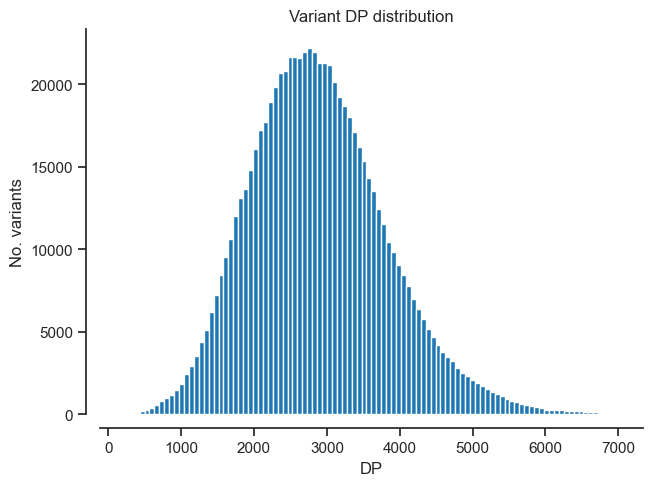

In [15]:
plot_variantpass_hist('DP', bins=100)

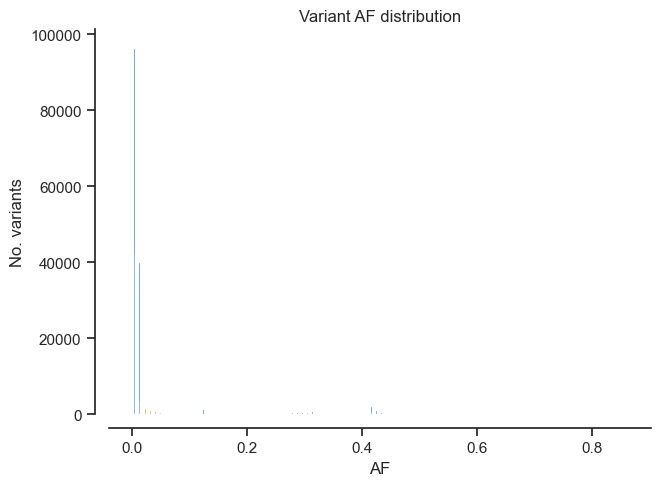

In [16]:
plot_variantpass_hist('AF', bins=100)

Let's examine our samples a bit more closely:

In [17]:
#extract genotypes from filtered data
genotypes = allel.GenotypeChunkedArray(callset['calldata/GT'])
genotypes_subset = genotypes.subset(variant_selection)
n_variants = len(variants_pass)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants

In [18]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    pop2color = {'M_hyperodae': palette[0], 'M_aethiopoides': palette[1]}
    colors = [pop2color[p] for p in df_samples.Species]
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[0]),
               mpl.patches.Patch(color=palette[1])]
    ax.legend(handles=handles, labels=['M_hyperodae', 'M_aethiopoides'], title='Species',
              bbox_to_anchor=(1, 1), loc='upper left')

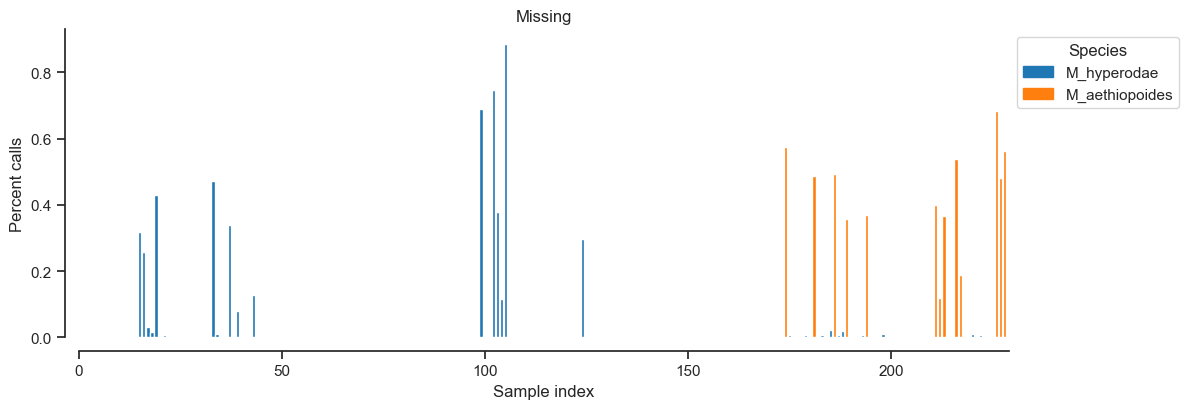

In [19]:
plot_genotype_frequency(pc_missing, 'Missing')

Generally missingness appears to be very low, despite very low numbers of sequencing reads for some of the samples. M aeth samples generally look dodgy as shit.

Do a quick PCA

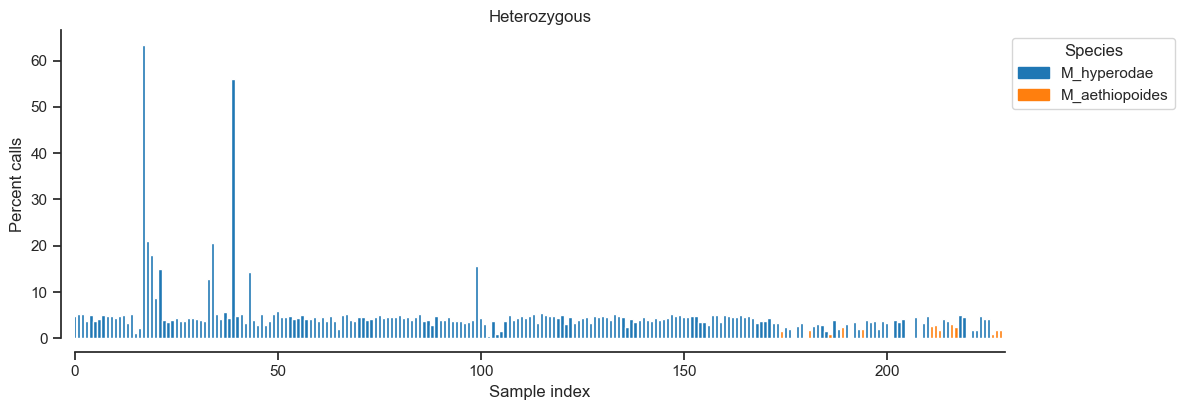

In [20]:
plot_genotype_frequency(pc_het, 'Heterozygous')

Generally it looks like the aehtiopoides samples have more missing data and generally are more homozylgous than the hyperodae samples.Hmm hmm hmm. Whether this is true or now, I don't trust heterozygous GTs from data this low coverage, so I'm going to remove individuals with coverage less than 5x and look again. On the other hand, there are heterozygous GTs, so that tells us something about their reproduction (eg not mitosis / apomixis)

In [21]:
g = allel.GenotypeChunkedArray(callset['calldata']['GT'])
ac = g.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
#count singletons
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))
#apply filter
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)


In [22]:
#Finally, transform the genotype data into a 2-dimensional matrix where each cell has the number of non-reference alleles per call. This is what we’ll use as the input to PCA.
gn = gf.to_n_alt()

In [23]:
#let's have a look at LD and prune if we need to
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

In [24]:
#%%time
#plot_ld(gn, 'Figure 1. Pairwise LD.')

### Figure XX: Linkage disequilibrium (LD) plot of the first 1K SNPs in the dataset. Key indicates R-squared value.

What we see here is long-range strong LD. You have SNPs from far away from each other in strong LD (perfectly correlated  - R2 =1) with one another. This is what we expect from a non-recombining asexual organism. I am not sure what the variation in LD means though - I need to think about this. But it's certainly consistent with our expectation. Perhaps it is reflective of ancestral sexual reproduction?

Normally what I would do is prune SNPs or GLs before using them in a PCA. Again, I'm in new territory and my understanding is still incomplete but would that apply here? I'll create a pruned and unpruned SNP set and use them for a PCA and see what we get.

In [25]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn
gnp = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=1)
#normally just one iteration but can do multiple if you want to see how many get taken

iteration 1 retaining 38227 removing 684804 variants


In [ ]:
plot_ld(gnp, 'Figure 2. Pairwise LD after LD pruning.')

Still lots of linked sites. Unsurprising - how many do we have of each?

In [ ]:
#flatten from array to GT matrix for PCA
gnu = gn[:]
gnp = gnp[:]

Run conventional PCA on pruned and unpruned GTs:

In [ ]:
coords_unpruned, model_unpruned = allel.pca(gnu[:], n_components=10, scaler='patterson')
coords_pruned, model_pruned = allel.pca(gnp[:], n_components=10, scaler='patterson')

Read metadata:

In [ ]:
population = df_samples.Location.unique()

In [ ]:
site_colours = {
"Ruakura": "#5A5156",
"Lincoln" : "#E4E1E3",
"Ascasubi" : "#F6222E",
"Bariloche" : "#FE00FA",
"Featherston" : "#16FF32",
"Fortrose" : "#3283FE",
"Hawkes_Bay" : "#FEAF16",
"La_Serena" : "#B00068",
"Mararoa" : "#1CFFCE",
"Mendoza" : "#90AD1C",
"Mossburn" : "#2ED9FF",
"Porto_Alegre" : "#DEA0FD",
"Rio_Negro" : "#AA0DFE",
"Ruakaka" : "#F8A19F",
"South_Chile" : "#325A9B" ,
"Uruguay" : "#C4451C",
"West_Coast_Site_1" : "#1C8356"
}


species_colours = {
    'M_hyperodae': '#00FFFF',
    'M_aethiopoides': '#90EE90',
}

In [ ]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    #populations = df_samples[sample_population].unique()
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title,  sample_metadata, sample_population=None):
    if sample_population is None:
        sample_population = sample_metadata['Species'].values
    else:
        sample_population = sample_metadata[sample_population].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

In [ ]:
populations = df_samples.Species.unique()
pop_colours=species_colours
fig_pca(coords_unpruned, model_unpruned, 'Figure 4. Conventional PCA, Species, Unpruned GTs', df_samples, sample_population = 'Species')

In [ ]:
populations = df_samples.Location.unique()
pop_colours=site_colours
fig_pca(coords_unpruned, model_unpruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Location')

In [ ]:
populations = df_samples.Location.unique()
pop_colours=site_colours
fig_pca(coords_pruned, model_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Location')

In [ ]:
populations = df_samples.Species.unique()
pop_colours=species_colours
fig_pca(coords_pruned, model_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Species')

In these PCAs we see the M. aethiopoides: hyperodae split driving most of the variation. In the pruned sample set, the amount of variation explained by this decreases almost tenfold. What could be causing this? Inversion, perhaps? Either way, in both plots the M_aeth, M_hyp split is dominating the samples. These samples are also mostly poorly sequenced. Let's get rid of them, and other samples with coverage < 5.df_samples.Species == 'M_hyperodae' & df_samples.meandepth_Mh_scaffold_1 > 5



In [ ]:
df_samples.meandepth_Mh_scaffold_1 > 5
mhyp_samples = df_samples[(df_samples.Species == 'M_hyperodae') & (df_samples.meandepth_Mh_scaffold_1 > 5)]
mhyp_sample_indices = mhyp_samples.callset_index.values
gt_hyp = gf.take(mhyp_sample_indices, axis=1)
unlinked_loci = allel.locate_unlinked(gn)
unlinked_gts = gf.subset(unlinked_loci)
mhyp_gt  = unlinked_gts.take(mhyp_sample_indices, axis=1)
unlinked_gts = gf.subset(unlinked_loci)
mhyp_gt  = unlinked_gts.take(mhyp_sample_indices, axis=1)
#plot_ld(mhyp_gt.to_n_alt()[:1000], 'Figure 2. Pairwise LD after LD pruning.')

In [ ]:
gn.shape

In [ ]:
ac = mhyp_gt.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
#count singletons
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))
#apply filter
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = mhyp_gt.compress(flt, axis=0)
mhalt = gf.to_n_alt()
#do pca
coords_mhonly_pruned, model_mhonly_pruned = allel.pca(mhalt[:], n_components=10, scaler='patterson')
#subset metadata

In [ ]:
populations = mhyp_samples.Location.unique()
pop_colours=site_colours
fig_pca(coords_mhonly_pruned, model_mhonly_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs',  mhyp_samples, sample_population = 'Location')

In [ ]:
coords3, model3 = allel.pca(mhalt[:], n_components=10, scaler=None)

In [ ]:
fig_pca(coords3, model3, 'Figure 5. Conventional PCA, Site, Unpruned GTs',  mhyp_samples, sample_population = 'Location')